# 0. 환경설정

In [2]:
import pandas as pd
import numpy as np
from numbers import Number

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

# 1. 데이터 업로드

In [151]:
print('## 1.1) 로그 데이터 업로드 ## ')
start_time = time.time()  # 시작 시간 저장
log_data = pd.read_csv('./data/log_total.csv', usecols = list(range(1,11)), nrows =  1000000, # nrows =  100000, 
                  dtype = {'timeOnPage' : 'int16',
                           'user_code' : 'int32',
                           'session_sort' : 'int8',
                           'session_length' : 'int16'})

log_data['Datetime'] = pd.to_datetime(log_data['Datetime'])
print("time :", time.time() - start_time) # 현재시간 - 시작시간
print(log_data.shape)



print('## 1.2) 구매기록 데이터 업로드 ##')
start_time = time.time()  # 시작 시간 저장
raw_data = pd.read_csv('./data/raw_data.csv', nrows = 100000) # nrows = 100000
print("time :", time.time() - start_time) # 현재시간 - 시작시간
print(raw_data.shape)

## 1.1) 로그 데이터 업로드 ## 
time : 3.4288828372955322
(1000000, 10)
## 1.2) 구매기록 데이터 업로드 ##
time : 1.2623662948608398
(100000, 52)


# 2. 데이터 전처리 

#### 2.1) timeOnPage, Session 이상치 확인

In [ ]:
# log_data['timeOnPage'].sort_values(ascending = False)[:20]

#### 2.2) 시간, 세션 순서대로 정렬

In [152]:
log_data.sort_values(['Datetime','session'], ascending = True, inplace = True)

#### 2.3) Product_id 추출 + 구매 매칭 작업 + 고객 선호도

- 멀티프로세싱 적용해보기

In [193]:
# 1. URL에서 / 별 분류
def func(str):
    return str.split('/')[1] # '/' 기준 2번째 

# 2. URL에서 goods 정제 및 고객 선호도 생성
def find_product_id(data):
    df = data.copy()
    
    ''' 1. 유저가 살펴본 product_id 추출'''
    # 1. pagePath 에서 URL 카테고리 분류
    print('(1/5) pagePath에서 URL PageStatus 변수 생성중...')
    df['page_status'] = list(map(func, df['pagePath']))
    
    # 2. 불필요한 PageStatus 제거 (Curation_) 으로 시작함.
    idx = df[df['page_status'].str.contains('curation_')].index
    df.drop(idx, inplace = True)
    
    # 2. 분류된 카테고리에서 goods 정제 
    #df = df[df['page_status'] == 'goods']

    # 3. 'goods_no=' = 'Product_id'추출
    print('(2/5) 분류된 Goods에서 Product_id 추출중... ')
    df.reset_index(drop = True, inplace = True)
    start_no = df['pagePath'].apply(lambda x : x.find('goods_no=')) + 9
    end_no = start_no + 10
    
    shared_list = list()   
    for i in tqdm(range(df.shape[0])):   
        item_name = df['pagePath'].values[i][start_no.values[i]:end_no.values[i]]
        shared_list.append(item_name)
        
    product_id = pd.DataFrame({"product_id" : shared_list})
    df = pd.concat([df, product_id], axis = 1)
    
    # goods에서 확인된 Product_id를 문자형으로 변환, 나머지 0으로 변환
    print('(3/5) Product_id를 문자형으로 변환중...')
    df['product_id'] = pd.to_numeric(df['product_id'], errors='coerce')
    df['product_id'].fillna(0, inplace = True)
    df['product_id'] = df['product_id'].astype(int)
    df['product_id'] = df['product_id'].astype(str)
    
    # 구매매칭 시간대 확인을 위한 변수 생성
    print('(4/5) 구매매칭 컬럼 생성중...')
    df['Datetime'] = df['Datetime'].astype(str)
    df['구매매칭'] = df['Datetime'].str[5:7] +'월_'+ df['Datetime'].str[8:10]+'일_' + df['Datetime'].str[11:13]+'시'
    
    # 고객 선호도 함수생성(timeOnPage * Click)
    print('(5/5) 고객 선호도 함수 생성중...')
    # 1. 시간 순서에 따른 product_id 별 Rank 생성
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df['Rank'] = df.groupby(['user_code','product_id'])['Datetime'].rank(method='min', ascending=True)
    
    # 2. 고객 선호도 함수 생성 (조화 평균)
    df['preference']  = 2 * ((df['timeOnPage'] * df['Rank']) / (df['timeOnPage'] + df['Rank']))
    
    # 210918 : Rank와 timeOnPage에 대한 이상치 정의 후 전처리 필요
    print('=============== 완료 ===============')
    
    df.rename(columns = {'user_code':'user_id'}, inplace = True)
    return df

user_product_data = find_product_id(log_data)

(1/5) pagePath에서 URL PageStatus 변수 생성중...
(2/5) 분류된 Goods에서 Product_id 추출중... 


100%|██████████████████████████████████████████████████████████████████████| 999994/999994 [00:04<00:00, 236996.24it/s]


(3/5) Product_id를 문자형으로 변환중...
(4/5) 구매매칭 컬럼 생성중...
(5/5) 고객 선호도 함수 생성중...
=============== 완료 ===============


In [195]:
user_product_data = user_product_data[['session', 'user_id', '구매매칭', 'page_status','product_id', 'timeOnPage', 'Datetime',
       'Datetime_roll', 'time_gap', 'session_sort', 'session_length','Rank', 'preference']]
user_product_data.head()

,session,user_id,구매매칭,page_status,product_id,timeOnPage,Datetime,Datetime_roll,time_gap,session_sort,session_length,Rank,preference
0,1375271_1,1375271,01월_01일_00시,mypage,0,17,2020-01-01,2020-01-01 00:00:00,0 days 00:00:00,1,26,1.0,1.888889
1,1375271_1,1375271,01월_01일_00시,mypage,0,8,2020-01-01,2020-01-01 00:01:00,0 days 00:01:00,1,26,1.0,1.777778
2,1541251_1,1541251,01월_01일_00시,goods,1904434862,19,2020-01-01,2020-01-01 00:00:00,0 days 00:00:00,1,17,1.0,1.900000
3,1541251_1,1541251,01월_01일_00시,goods,1912878161,15,2020-01-01,2020-01-01 00:00:00,0 days 00:00:00,1,17,1.0,1.875000
4,1541251_1,1541251,01월_01일_00시,search,0,77,2020-01-01,2020-01-01 00:01:00,0 days 00:01:00,1,17,1.0,1.974359


# 2.4) 구매기록 데이터 전처리

#### 2.4.1) 필요없는 컬럼 및 유저ID 없는 경우 제거

In [208]:
# 1. 구매일자 매칭 컬럼 생성
raw_data['결제일자'] = raw_data['결제일자'].astype(str)
raw_data['구매매칭'] = raw_data['결제일자'].str[4:6] +'월_'+raw_data['결제일자'].str[6:8]+'일_'+raw_data['결제시간대']

# 2. 필요한 컬럼 선정
purchase_df = raw_data[['고객 ID','상품코드', '구매매칭', '구매그룹명', '구매그룹코드', '실주문건수', '실주문수량', '총판매액(정상가)',
       '총판매액(판매가)', '배송일자', '요일', '주문매체명',
       '채널명', '쇼핑몰명', '주문생성구분명', '조직명', '표준상품군명', '브랜드명',
       '컨텐츠코드', '상품명', '단품명', '나이', '성별', '가입일시', '임직원여부',
       '회원유형', '복지포인트 사용여부', '결품여부', 'EMAIL동의여부',
       'SMS동의여부', '결제수단', '주문금액', '주문수량', '정상가', '판매가', '할인액(합계)', '실매출액',
       '취소금액', '반품금액', '교환금액', '복지포인트 사용금액', '멤버십등급명']]

purchase_df.rename(columns={'고객 ID':'user_id', '상품코드' : 'product_id'}, inplace = True)

# 3. 결제일자/결제시간대 순차내림 정렬
purchase_df.sort_values('구매매칭', ascending = True, inplace = True)

# 4. 유저 ID가 없는 경우 제거
purchase_df = purchase_df[purchase_df['user_id'].notnull()]
purchase_df.reset_index(inplace = True, drop = True)
print(purchase_df.shape)

(72085, 42)


## 2.5) 로그와 구매기록 필터링 (product_id와 user_id가 둘다 조회되는 데이터)

In [209]:
print("구매 기록 중 고유 제품 갯수 : ",purchase_df['product_id'].nunique())
print("클릭스트림 기록 중 고유 제품 갯수 : ",user_product_data['product_id'].nunique())
print('\n')
print("구매 기록 중 고유 유저 명 : ",purchase_df['user_id'].nunique())
print("클릭스트림 기록 중 고유 유저 명 : ",user_product_data['user_id'].nunique())

구매 기록 중 고유 제품 갯수 :  32481
클릭스트림 기록 중 고유 제품 갯수 :  49772


구매 기록 중 고유 유저 명 :  58922
클릭스트림 기록 중 고유 유저 명 :  12541


In [212]:
# 1차) 상품 코드가 조회되는 Product_id 조회 (product_id 중심, 구매한 사람과 구매하지 않은 사람들이 섞여있음)
# pur_df = purchase_df[purchase_df['product_id'].isin(user_product_data['product_id'])]
# log_df = user_product_data[user_product_data['product_id'].isin(purchase_df['product_id'])]

# 2차) 고객 ID가 조회되는 user_code 조회 (user_id중심, 구매한 사람들만 있음)
pur_df = purchase_df[purchase_df['user_id'].isin(user_product_data['user_id'])]
log_df = user_product_data[user_product_data['user_id'].isin(purchase_df['user_id'])]

# -> 특정 Product_id에 대한 Browsing을 했어도, 구매 기록이 없다면, 결국 구매하지 않은것!
# -> 그러므로, 고객 ID가 조회되는 것으로 사용해야만 할듯(성능이 낮겠지)
# -> 반면에, Product_id까지 조회한다면, 클릭스트림 데이터에는 결국 한번이라도 구매한 사람들에 대한 표본 집단을 의미
# -> 해석의 차이일듯.(성능이 높겠지)

- 참고) 1차)product_id와 2차)user_code의 조인하는 결과가 다르다! -> 1차는 "구매하지않은 사람" 포함, 2차는 "구매한 사람들만" 포함

In [214]:
print("구매기록과 로그기록의 고유ID 수 (동일하면 구매한 사람들만 있다는 것) : ",pur_df['user_id'].nunique(), log_df['user_id'].nunique())
print("{}는 구매기록, {}는 로그기록".format(pur_df.shape, log_df.shape))

구매기록과 로그기록의 고유ID 수 (동일하면 구매한 사람들만 있다는 것) :  1427 1427
(2129, 42)는 구매기록, (296416, 13)는 로그기록


## 2.3) 로그 데이터와 구매 데이터 확인

## 2.4) 로그데이터 + 구매 데이터 병합 전처리

# [작업중] reset_index 조심, 3개의 조건에 index가 모두 같아야함 ★

- 순서는 -> 로그 <> 구매 기록데이터 중 user_id와 product_id 필터링 후 -> order 세션 필터링

#### 2.5) 페이지 내 order가 있는 것들 확인

In [240]:
# page_status 한 컬럼에 모으기
session_df = pd.DataFrame(user_product_data.groupby('session')['page_status'].agg(','.join)).reset_index()
session_df.sort_values('session', inplace = True)
print(session_df.shape)
session_df.head() # page_status가 1개인 것은 제거하기

# for i in session_df['page_status']:
#     temp = i.split(',')
#     if (len(temp) == 1):
#         print(temp)
#         print('True')
#     else:
#         pass
# #######################################################################################################
# # order 가 있는 컬럼 중 1개만 있는가?
# temp_df = session_df[session_df['page_status'].str.contains('order')]
# temp_df.sort_values('session')
# # temp_df.head()

# # 1칸인데, order만 있는 경우도 있더라
# for i in temp_df['page_status']:
#     temp = i.split(',')
#     if (len(temp) == 1):
#         print(temp)
#         print('True')
#     else:
#         pass

,session,page_status
0,1000936_1,"dispctg,main,dispctg,main,shop,shop,main,mypag..."
1,1002205_1,"dispctg,main,main,dispctg,dispctg,dispctg,shop..."
2,1004212_1,event
3,1004212_10,shop
4,1004212_11,"goods,goods,goods,goods,goods,shop,dispctg,goo..."


#### 2.4) Goods인것에서 Product_id 뽑기

In [272]:
idx = user_product_data.loc[user_product_data['page_status'] == 'goods', 'product_id'].index
product_list = user_product_data.loc[idx,:'product_id']

product_df = pd.DataFrame(product_list.groupby('session')['product_id'].agg(','.join)).reset_index()
print(product_df.shape)
product_df.head()

(65668, 2)


,session,product_id
0,1000936_1,"1704178441,1907613048"
1,1004212_11,"1901214615,1903384665,1903384666,1912875310,19..."
2,1004212_12,"1905515147,1910765432,1911805110,1808948223,19..."
3,1004212_13,"1912874574,1910776030,1610059032,1910767646,19..."
4,1004212_15,1912918120


In [273]:
session_df = pd.merge(session_df, product_df, how = 'outer', on = 'session')
session_df.head()

,session,page_status,product_id
0,1000936_1,"dispctg,main,dispctg,main,shop,shop,main,mypag...","1704178441,1907613048"
1,1002205_1,"dispctg,main,main,dispctg,dispctg,dispctg,shop...",NaN
2,1004212_1,event,NaN
3,1004212_10,shop,NaN
4,1004212_11,"goods,goods,goods,goods,goods,shop,dispctg,goo...","1901214615,1903384665,1903384666,1912875310,19..."


In [274]:
session_df.loc[session_df[session_df['page_status'].str.contains('order')].index, 'order_class'] = '1'
session_df.fillna('0', inplace = True)

# 비율 9%
print(round(session_df['order_class'].value_counts()[1] / session_df['order_class'].value_counts()[0],2))

session_df

0.09


,session,page_status,product_id,order_class
0,1000936_1,"dispctg,main,dispctg,main,shop,shop,main,mypag...","1704178441,1907613048",0
1,1002205_1,"dispctg,main,main,dispctg,dispctg,dispctg,shop...",0,1
2,1004212_1,event,0,0
3,1004212_10,shop,0,0
4,1004212_11,"goods,goods,goods,goods,goods,shop,dispctg,goo...","1901214615,1903384665,1903384666,1912875310,19...",0
...,...,...,...,...
178621,996160_6,event,0,0
178622,996160_7,"goods,goods,event","1912885678,1910743357",0
178623,996160_8,event,0,0
178624,996160_9,event,0,0


### 관찰

In [278]:
session_df[session_df['order_class'] == '0']

,session,page_status,product_id,order_class
0,1000936_1,"dispctg,main,dispctg,main,shop,shop,main,mypag...","1704178441,1907613048",0
2,1004212_1,event,0,0
3,1004212_10,shop,0,0
4,1004212_11,"goods,goods,goods,goods,goods,shop,dispctg,goo...","1901214615,1903384665,1903384666,1912875310,19...",0
5,1004212_12,"goods,goods,main,main,goods,shop,mypage,shop,m...","1905515147,1910765432,1911805110,1808948223,19...",0
...,...,...,...,...
178621,996160_6,event,0,0
178622,996160_7,"goods,goods,event","1912885678,1910743357",0
178623,996160_8,event,0,0
178624,996160_9,event,0,0


In [279]:
session_df[session_df['order_class'] == '1']

,session,page_status,product_id,order_class
1,1002205_1,"dispctg,main,main,dispctg,dispctg,dispctg,shop...",0,1
22,1004212_28,"mypage,cart,goods,goods,shop,mypage,order,good...","2001001369,2001001716,2001001716",1
24,1004212_3,"mypage,mypage,mypage,goods,order,goods,order,g...","1609026604,1609026604,1609026604,1609026604",1
51,1004611_24,"event,main,mypage,event,main,shop,dispctg,disp...","2001988907,1912865439,1912865581,1912865581,17...",1
59,1007551_1,"cart,goods,goods,goods,order","1901259447,1901259398,1901259447",1
...,...,...,...,...
178484,987990_13,"shop,goods,order,goods","2001978671,2001978671",1
178488,987990_17,"order,mypage,goods,order,mypage,order,goods,shop","1712471880,2001006181",1
178526,988626_30,"mypage,event,event,mypage,shop,order,shop,mypa...",0,1
178544,990950_2,"goods,order,mypage,mypage,mypage,main,order,sh...","1612108191,1612108191",1


In [267]:
temp.loc[1,'page_status'] # goods를 보지 않고 구매로 전환되었다는 것은, 이전 세션에서 cart에 담아두었다

'dispctg,main,main,dispctg,dispctg,dispctg,shop,order,cart,order,cart'

- 1) feature engineering : 0) graph theory, 1) 본 product 갯수, 2) cart 여부, 3) 이전세션 영향 
- 2) Discussion : 해당 세션에 대한 구매 확률(0~100)을 예측을 하므로써, 예측되는 높은 확률일 수록 타겟팅 프로모션 적용 가능 or 추천시스템 적용가능

- 아래 1,2,3) 조건을 통해 각각 0,1 class로 만들어서 최종 interaction이 있도록 <> 아니면 걍 order
- 세션에서 id를 찢어서 해당 id의 고객RFM을 확인할 수 있겠음 <> 근데 시간정보반영이 다름

# [작업중] 

In [ ]:
#  2. 조인 (구매여부) : 로그데이터와 구매기록데이터의 조건
#  2.1) 1. 구매날짜(시간대) + 2. 구매자중심 +  3. 세션 내 order 페이지 존재

#### 1) cond1 : 세션 내 order가 있는가

In [ ]:
# cond1 : 세션 내 order가 있는가
session_df[session_df['page_status'].str.contains('order')].index
# 공통되는 Index로 합치기


In [ ]:
session_df[session_df['user_id'] 

#### 2) ccond2 : 사용자 ID가 일치하는가

In [215]:
# cond2 : 사용자 ID가 일치하는가
session_df[session_df['page_status'].str.contains('order')].index

In [220]:
pd.merge(log_df, pur_df, how = 'left', on =['user_id', '구매매칭', 'product_id']).head()

,session,user_id,구매매칭,page_status,product_id,timeOnPage,Datetime,Datetime_roll,time_gap,session_sort,session_length,Rank,preference,구매그룹명,구매그룹코드,실주문건수,실주문수량,총판매액(정상가),총판매액(판매가),배송일자,요일,주문매체명,채널명,쇼핑몰명,주문생성구분명,조직명,표준상품군명,브랜드명,컨텐츠코드,상품명,단품명,나이,성별,가입일시,임직원여부,회원유형,복지포인트 사용여부,결품여부,EMAIL동의여부,SMS동의여부,결제수단,주문금액,주문수량,정상가,판매가,할인액(합계),실매출액,취소금액,반품금액,교환금액,복지포인트 사용금액,멤버십등급명
0,1594821_1,1594821,01월_01일_00시,order,0,68,2020-01-01,2020-01-01 00:00:00,0 days 00:00:00,1,3,1.0,1.971014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1594821_1,1594821,01월_01일_00시,cart,0,20,2020-01-01,2020-01-01 00:01:00,0 days 00:01:00,1,3,1.0,1.904762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2786412_1,2786412,01월_01일_00시,goods,1808953110,57,2020-01-01,2020-01-01 00:00:00,0 days 00:00:00,1,10,1.0,1.965517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2786412_1,2786412,01월_01일_00시,goods,1902302138,244,2020-01-01,2020-01-01 00:05:00,0 days 00:05:00,1,10,1.0,1.991837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3230738_1,3230738,01월_01일_00시,goods,1810065869,90,2020-01-01,2020-01-01 00:01:00,0 days 00:01:00,1,2,1.0,1.978022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3) cond3  세션 내 order 페이지의 시간 

In [ ]:
# cond3  세션 내 order 페이지의 시간 


#### 4) 조건문 병합

In [20]:
cond1 = (True)  # 세션 내 order 존재 
cond2 = (True)  # 고객 ID + user_code <> product_id는 정확히 뭘샀는지 알 수 있을까? 글세...
cond3 = (False) # 결제시간 + 구매매칭

if cond1 and cond2 and cond3 :
    print('True') # 구매 = 1 
else:
    print('False') # 구매 = 0 

False


In [ ]:
1. page_status를 리스트[]로 만들어 놓기 : 그 안에 order가 있나?
2. preference는 goods가 있는 것만 합산! 평균!?

## [작성중] 2.4) 구매 데이터 전처리
- (Social Network Degree) + (RFM, 고객등급, 선호도 등) 2가지 이론으로 feature engineering

<AxesSubplot:>

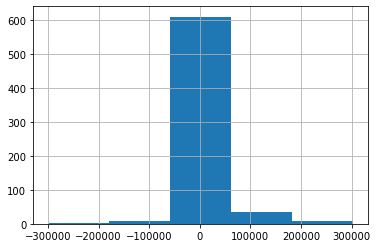

In [18]:
purchase_data.groupby('고객 ID')['실매출액'].sum().hist(bins = 5) # 5등급화 일 때, 정규분포를 이룬다, 

<AxesSubplot:>

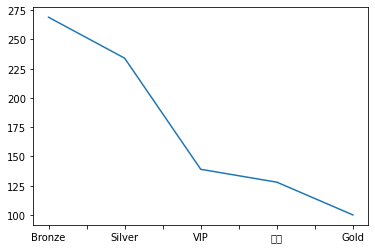

In [24]:
purchase_data['멤버십등급명'].value_counts().plot()

- (Graph theory) + (Customer behavior) 2가지 이론 중심 feature engineering
- 구매 여부 : 1) 구매기록데이터(해당 구매 시간) == 2)로그데이터(그 해당 세션 시간) 일치하나? 
- 구매 동기(의도) 요인이 이전 세션에서 영향을 줬을 수도 있고, 현재 세션에서 영향을 줬을 수도 있고
ex) 이전 세션에 한참 보다가, 오프라인 후 다음 세션에서 특정 패턴없이 바로 구매!
- ★ 해당 세션 구매 확률(0~1의 확률) 예측(MAP 성능평가) -> 구매하거나 하지 않았어도, 다음 세션에서 해당 Product_id에 대한 프로모션 사용
- ★ 그러기 위해서 해당 Input 데이터에 어떤 아이템을 관심있게 보았는지 Product_id를 넣기?.(Input엔 넣지않으면, 프로토타입 형식으로 썰 풀기)


- Purpose : 현재(?) 및 다음(?) 세션에 구매를 예측 했나?, 
- 현재 세션에서 구매를 예측하는건 실시간 프로모션
- 다음 세션에서 구매를 예측하는 것 또한 프로모션
#################################################################################################################### 
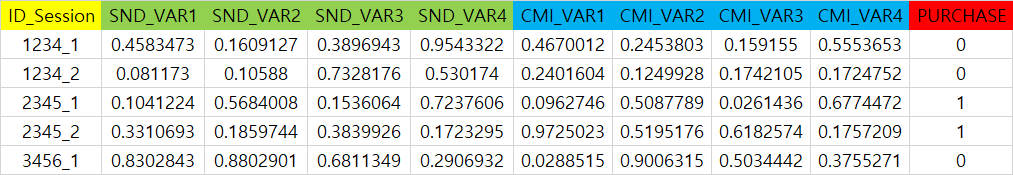

# 3. 데이터 저장(Ing~)

In [ ]:
time_log_data.to_csv('./data/210908_로그기록데이터.csv', index = False)
purchase_data.to_csv('./data/210908_구매기록데이터.csv', index = False)

# 4. 향후 전처리 진행 공간

In [18]:
######################################################
#
#  0. 정의
#  0.1) 사용할 컬럼들 정의    (로그데이터, 구매기록 데이터)
#  0.2) pagePath 정의하고 아닌 것들 싹 짜르기(main, dispctg, goods, login, main 등 이외 제거)
#
#
#  1. 삭제
#  1.1) 불필요한 컬럼/세션삭제 (로그데이터, 구매기록 데이터)
#
#
#  2. 조인 (구매여부) : 로그데이터와 구매기록데이터의 조건
#  2.1) 1. 구매날짜(시간대) + 2. 구매자중심 +  3. 세션 내 order 페이지 존재
#
#
#  3. 전처리
#  Graph theory + Customer Behavior 변수 생성
#  
#  Graph theory : 23개의 Graph metric
#
#  Customer Behavior : RFM, 고객선호도(시간가중치 적용 조화평균), 등급, 성별 등.
#
#
######################################################

- 탐색적 데이터 분석 필요 : 주요 결제시간, device 유형, 
- 멀티프로세성 전처리 : import multiprocessing as mp ; mp.cpu_count() # 병렬 처리하는 법 : https://jonsyou.tistory.com/27